<a href="https://colab.research.google.com/github/ved-sharma/Detecting_Metastasis_Doorways_in_Breast_Cancer_with_ZeroCostDL4Mic/blob/main/TMEM_detection_YOLOv2_ZeroCostDL4Mic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook links to the GitHub repository at:  
https://github.com/ved-sharma/Detecting_Metastasis_Doorways_in_Breast_Cancer_with_ZeroCostDL4Mic

# **Deep Learning model for "metastasis doorway" (TMEM) detection using ZeroCostDL4Mic notebook**
---

<font size = 3> **YOLOv2** is a deep-learning method designed to perform object detection and classification of objects in images. YOLOv2 is trained on images with class annotations in the form of bounding boxes drawn around the objects of interest. The images are downsampled by a convolutional neural network (CNN) and objects are classified in two final fully connected layers in the network. YOLOv2 learns classification and object detection simultaneously by taking the whole input image into account, predicting many possible bounding box solutions, and then using regression to find the best bounding boxes and classifications for each object.

---

<font size = 4>**Acknowledgement**

<font size = 3>This notebook is part of the [Zero-Cost Deep-Learning for Microscopy (ZeroCostDL4Mic)](https://github.com/HenriquesLab/DeepLearning_Collab/wiki) project and based on the following papers:

von Chamier L et al. Democratising deep learning for microscopy with ZeroCostDL4Mic. Nat Commun. 2021 Apr 15;12(1):2276. PMID: [33859193](https://pubmed.ncbi.nlm.nih.gov/33859193/)

J. Redmon and A. Farhadi, "YOLO9000: Better, Faster, Stronger," 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017, pp. 6517-6525, doi: [10.1109/CVPR.2017.690](https://ieeexplore.ieee.org/document/8100173).

#**0. Before getting started**
---
<font size = 3> This model requires as input a set of images (currently .jpg and .png) and as target a list of annotation files in Pascal VOC format. Please follow these [instructions](https://github.com/ved-sharma/PASCAL_VOC_xml_generator_ImageJ_Fiji) if you would like to create your Pascal VOC annotations file using [ImageJ/Fiji](https://imagej.net/). The annotation files should have the exact same name as the input files, except with an .xml instead of the .jpg or .png extension. 

<font size = 3>Put your images and annotations file in your Google Drive. Here's a common data structure that can work:
* Training dataset
  - Folder 1: named "Training_images" containing input images (img_1.png, img_2.png, ...)
  - Folder 2: named "Training_annotations" containing Bounding box annotations (img_1.xml, img_2.xml, ...)
* Test dataset
  - Folder 3: named "Test_images" containing images for predictions
  - Folder 4: Empty folder named "Test_annotations" where the TMEM detected images will be saved
* Folder 5: Empty folder named "model" to save your trained deep learning model as a .h5 file


# **1. Install YOLOv2 and Dependencies**
---

## **1.1. Install key dependencies**
<font size = 4> 

In [1]:
#@markdown ##Install YOLOv2 and dependencies

!pip install pascal-voc-writer
!pip install fpdf
!pip install PTable
!pip install h5py==2.10

#Force session restart
exit(0)

  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40722 sha256=7fb8259b4bef7f489b4cd99a6e6d83fbabf64803e42feda3415ea0cabb1db854
  Stored in directory: /root/.cache/pip/wheels/d7/ca/c8/86467e7957bbbcbdf4cf4870fc7dc95e9a16404b2e3c3a98c3
Successfully built fpdf
  Created wheel for PTable: filename=PTable-0.9.2-py3-none-any.whl size=22925 sha256=a1899c2305e7d5f7d5c1852e33de3b70f97ef9b41546c93ca0d025f583589631
  Stored in directory: /root/.cache/pip/wheels/33/df/2f/674985b3f8a2de3f96357d1eadef5110f74fa91b3785e52a54
Successfully built PTable
     |████████████████████████████████| 2.9 MB 8.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires h5py~=3.1.0, but you have h5py 2.1

## **1.2. Load key dependencies**

In [1]:
Notebook_version = '1.13'
Network = 'YOLOv2'

from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory 
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]

#@markdown ##Load Key Dependencies
%tensorflow_version 1.x

from pascal_voc_writer import Writer
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import csv
import random
import pprint
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
import math
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import matplotlib.patches as patches
import tensorflow as tf
import pandas as pd
import os
import shutil
from skimage import io
from sklearn.metrics import average_precision_score

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout, Reshape, Activation, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.applications.mobilenet import MobileNet
from keras.applications import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy
from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers
from keras.utils import Sequence
import xml.etree.ElementTree as ET
from collections import OrderedDict, Counter
import json
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import copy
import cv2
from tqdm import tqdm
from tempfile import mkstemp
from shutil import move, copymode
from os import fdopen, remove
from fpdf import FPDF, HTMLMixin
from datetime import datetime
from pip._internal.operations.freeze import freeze
import subprocess as sp
from prettytable import from_csv

ia.seed(1)
# imgaug uses matplotlib backend for displaying images
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import re
import glob

#Here, we import a different github repo which includes the map_evaluation.py
!git clone https://github.com/rodrigo2019/keras_yolo2.git

#Here, we import the main github repo for this notebook and move it to the gdrive
!git clone https://github.com/experiencor/keras-yolo2.git

#Now, we move the map_evaluation.py file to the main repo for this notebook.
#The source repo of the map_evaluation.py can then be ignored and is not further relevant for this notebook.
shutil.move('/content/keras_yolo2/keras_yolov2/map_evaluation.py','/content/keras-yolo2/map_evaluation.py')

#We remove this branch from the notebook, to avoid confusion.
shutil.rmtree('/content/keras_yolo2')

os.chdir('/content/keras-yolo2')


from backend import BaseFeatureExtractor, FullYoloFeature
from preprocessing import parse_annotation, BatchGenerator



def plt_rectangle(plt,label,x1,y1,x2,y2,fontsize=14):
    '''
    == Input ==
    
    plt   : matplotlib.pyplot object
    label : string containing the object class name
    x1    : top left corner x coordinate
    y1    : top left corner y coordinate
    x2    : bottom right corner x coordinate
    y2    : bottom right corner y coordinate
    '''
    linewidth = 2
    color = "red"
#    plt.text(x1,y1,label,fontsize=fontsize,backgroundcolor="gray")
    plt.text(x1,y1,label,fontsize=fontsize, fontweight='bold')
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color)

def extract_single_xml_file(tree,object_count=True):
    Nobj = 0
    row  = OrderedDict()
    for elems in tree.iter():

        if elems.tag == "size":
            for elem in elems:
                row[elem.tag] = int(elem.text)
        if elems.tag == "object":
            for elem in elems:
                if elem.tag == "name":
                    row["bbx_{}_{}".format(Nobj,elem.tag)] = str(elem.text)              
                if elem.tag == "bndbox":
                    for k in elem:
                        row["bbx_{}_{}".format(Nobj,k.tag)] = float(k.text)
                    Nobj += 1
    if object_count == True:
      row["Nobj"] = Nobj
    return(row)

def count_objects(tree):
  Nobj=0
  for elems in tree.iter():
    if elems.tag == "object":
      for elem in elems:
        if elem.tag == "bndbox":
          Nobj += 1
  return(Nobj)

def compute_overlap(a, b):
    """
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua

def compute_ap(recall, precision):
  """ Compute the average precision, given the recall and precision curves.
  Code originally from https://github.com/rbgirshick/py-faster-rcnn.

  # Arguments
      recall:    The recall curve (list).
      precision: The precision curve (list).
  # Returns
      The average precision as computed in py-faster-rcnn.
  """
  # correct AP calculation
  # first append sentinel values at the end
  mrec = np.concatenate(([0.], recall, [1.]))
  mpre = np.concatenate(([0.], precision, [0.]))

  # compute the precision envelope
  for i in range(mpre.size - 1, 0, -1):
      mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

  # to calculate area under PR curve, look for points
  # where X axis (recall) changes value
  i = np.where(mrec[1:] != mrec[:-1])[0]

  # and sum (\Delta recall) * prec
  ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
  return ap   

def load_annotation(image_folder,annotations_folder, i, config):
  annots = []
  imgs, anns = parse_annotation(annotations_folder,image_folder,config['model']['labels'])
  for obj in imgs[i]['object']:
      annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], config['model']['labels'].index(obj['name'])]
      annots += [annot]

  if len(annots) == 0: annots = [[]]

  return np.array(annots)

def _calc_avg_precisions(config,image_folder,annotations_folder,weights_path,iou_threshold,score_threshold):

  # gather all detections and annotations
  all_detections = [[None for _ in range(len(config['model']['labels']))] for _ in range(len(os.listdir(image_folder)))]
  all_annotations = [[None for _ in range(len(config['model']['labels']))] for _ in range(len(os.listdir(annotations_folder)))]

  for i in range(len(os.listdir(image_folder))):
      raw_image = cv2.imread(os.path.join(image_folder,sorted(os.listdir(image_folder))[i]))
      raw_height, raw_width, _ = raw_image.shape
      #print(raw_height)
      # make the boxes and the labels
      yolo = YOLO(backend             = config['model']['backend'],
          input_size          = config['model']['input_size'], 
          labels              = config['model']['labels'], 
          max_box_per_image   = config['model']['max_box_per_image'],
          anchors             = config['model']['anchors'])
      yolo.load_weights(weights_path)
      pred_boxes = yolo.predict(raw_image,iou_threshold=iou_threshold,score_threshold=score_threshold)

      score = np.array([box.score for box in pred_boxes])
      #print(score)
      pred_labels = np.array([box.label for box in pred_boxes])
      #print(len(pred_boxes))
      if len(pred_boxes) > 0:
          pred_boxes = np.array([[box.xmin * raw_width, box.ymin * raw_height, box.xmax * raw_width,
                                  box.ymax * raw_height, box.score] for box in pred_boxes])
      else:
          pred_boxes = np.array([[]])

      # sort the boxes and the labels according to scores
      score_sort = np.argsort(-score)
      pred_labels = pred_labels[score_sort]
      pred_boxes = pred_boxes[score_sort]

      # copy detections to all_detections
      for label in range(len(config['model']['labels'])):
          all_detections[i][label] = pred_boxes[pred_labels == label, :]

      annotations = load_annotation(image_folder,annotations_folder,i,config)

      # copy ground truth to all_annotations
      for label in range(len(config['model']['labels'])):
          all_annotations[i][label] = annotations[annotations[:, 4] == label, :4].copy()

  # compute mAP by comparing all detections and all annotations
  average_precisions = {}
  F1_scores = {}
  total_recall = []
  total_precision = []
  
  with open(QC_model_folder+"/Quality Control/QC_results.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["class", "false positive", "true positive", "false negative", "recall", "precision", "accuracy", "f1 score", "average_precision"])  
  
    for label in range(len(config['model']['labels'])):
        false_positives = np.zeros((0,))
        true_positives = np.zeros((0,))
        scores = np.zeros((0,))
        num_annotations = 0.0

        for i in range(len(os.listdir(image_folder))):
            detections = all_detections[i][label]
            annotations = all_annotations[i][label]
            num_annotations += annotations.shape[0]
            detected_annotations = []

            for d in detections:
                scores = np.append(scores, d[4])

                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)
                    continue

                overlaps = compute_overlap(np.expand_dims(d, axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)

        # no annotations -> AP for this class is 0 (is this correct?)
        if num_annotations == 0:
            average_precisions[label] = 0
            continue

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
        total_recall.append(recall)
        total_precision.append(precision)
        #print(precision)
        # compute average precision
        average_precision = compute_ap(recall, precision)
        average_precisions[label] = average_precision

        if len(precision) != 0:
          F1_score = 2*(precision[-1]*recall[-1]/(precision[-1]+recall[-1]))
          F1_scores[label] = F1_score
          writer.writerow([config['model']['labels'][label], str(int(false_positives[-1])), str(int(true_positives[-1])), str(int(num_annotations-true_positives[-1])), str(recall[-1]), str(precision[-1]), str(true_positives[-1]/num_annotations), str(F1_scores[label]), str(average_precisions[label])])
        else:
          F1_score = 0
          F1_scores[label] = F1_score
          writer.writerow([config['model']['labels'][label], str(0), str(0), str(0), str(0), str(0), str(0), str(F1_score), str(average_precisions[label])])
    return F1_scores, average_precisions, total_recall, total_precision


def show_frame(pred_bb, pred_classes, pred_conf, gt_bb, gt_classes, class_dict, background=np.zeros((512, 512, 3)), show_confidence=True):
    """
    Here, we are adapting classes and functions from https://github.com/MathGaron/mean_average_precision
    """
    """
    Plot the boundingboxes
    :param pred_bb: (np.array)      Predicted Bounding Boxes [x1, y1, x2, y2] :     Shape [n_pred, 4]
    :param pred_classes: (np.array) Predicted Classes :                             Shape [n_pred]
    :param pred_conf: (np.array)    Predicted Confidences [0.-1.] :                 Shape [n_pred]
    :param gt_bb: (np.array)        Ground Truth Bounding Boxes [x1, y1, x2, y2] :  Shape [n_gt, 4]
    :param gt_classes: (np.array)   Ground Truth Classes :                          Shape [n_gt]
    :param class_dict: (dictionary) Key value pairs of classes, e.g. {0:'dog',1:'cat',2:'horse'}
    :return:
    """
    n_pred = pred_bb.shape[0]
    n_gt = gt_bb.shape[0]
    n_class = int(np.max(np.append(pred_classes, gt_classes)) + 1)
    #print(n_class)
    if len(background.shape) < 3:
      h, w = background.shape
    else:
      h, w, c = background.shape

    ax = plt.subplot("111")
    ax.imshow(background)
    cmap = plt.cm.get_cmap('hsv')

    confidence_alpha = pred_conf.copy()
    if not show_confidence:
        confidence_alpha.fill(1)

    for i in range(n_pred):
        x1 = pred_bb[i, 0]# * w
        y1 = pred_bb[i, 1]# * h
        x2 = pred_bb[i, 2]# * w
        y2 = pred_bb[i, 3]# * h
        rect_w = x2 - x1
        rect_h = y2 - y1
        #print(x1, y1)
        ax.add_patch(patches.Rectangle((x1, y1), rect_w, rect_h,
                                       fill=False,
                                       edgecolor=cmap(float(pred_classes[i]) / n_class),
                                       linestyle='dashdot',
                                       alpha=confidence_alpha[i]))

    for i in range(n_gt):
        x1 = gt_bb[i, 0]# * w
        y1 = gt_bb[i, 1]# * h
        x2 = gt_bb[i, 2]# * w
        y2 = gt_bb[i, 3]# * h
        rect_w = x2 - x1
        rect_h = y2 - y1
        ax.add_patch(patches.Rectangle((x1, y1), rect_w, rect_h,
                                       fill=False,
                                       edgecolor=cmap(float(gt_classes[i]) / n_class)))

    legend_handles = []

    for i in range(n_class):
        legend_handles.append(patches.Patch(color=cmap(float(i) / n_class), label=class_dict[i]))
    
    ax.legend(handles=legend_handles)
    plt.show()

class BoundBox:
    """
    Here, we are adapting classes and functions from https://github.com/MathGaron/mean_average_precision
    """
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape
    #Changes in box color added by LvC
    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)
        if box.get_label() == 0:
          cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
        elif box.get_label() == 1:
          cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        else:
          cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 3)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(round(box.get_score(),3)), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image_h, 
                    (0,0,0), 2)
    #print(box.get_label())    
    return image          

#Function added by LvC
def save_boxes(image_path, boxes, labels):#, save_path):
    image = cv2.imread(image_path)
    image_h, image_w, _ = image.shape
    save_boxes =[]
    save_boxes_names = []
    save_boxes.append(os.path.basename(image_path))
    save_boxes_names.append(os.path.basename(image_path))
    for box in boxes:
        # xmin = box.xmin
        save_boxes.append(int(box.xmin*image_w))
        save_boxes_names.append(int(box.xmin*image_w))
        # ymin = box.ymin
        save_boxes.append(int(box.ymin*image_h))
        save_boxes_names.append(int(box.ymin*image_h))
        # xmax = box.xmax
        save_boxes.append(int(box.xmax*image_w))
        save_boxes_names.append(int(box.xmax*image_w))
        # ymax = box.ymax
        save_boxes.append(int(box.ymax*image_h))
        save_boxes_names.append(int(box.ymax*image_h))
        score = box.get_score()
        save_boxes.append(score)
        save_boxes_names.append(score)
        label = box.get_label()
        save_boxes.append(label)
        save_boxes_names.append(labels[label])
    
    #This file will be for later analysis of the bounding boxes in imagej
    if not os.path.exists('/content/predicted_bounding_boxes.csv'):
      with open('/content/predicted_bounding_boxes.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        specs_list = ['filename']+['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']*len(boxes)
        csvwriter.writerow(specs_list)
        csvwriter.writerow(save_boxes)
    else:
      with open('/content/predicted_bounding_boxes.csv', 'a+', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(save_boxes)
    
    if not os.path.exists('/content/predicted_bounding_boxes_names.csv'):
      with open('/content/predicted_bounding_boxes_names.csv', 'w', newline='') as csvfile_names:
        csvwriter = csv.writer(csvfile_names, delimiter=',')
        specs_list = ['filename']+['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']*len(boxes)
        csvwriter.writerow(specs_list)
        csvwriter.writerow(save_boxes_names)
    else:
      with open('/content/predicted_bounding_boxes_names.csv', 'a+', newline='') as csvfile_names:
        csvwriter = csv.writer(csvfile_names)
        csvwriter.writerow(save_boxes_names)

def add_header(inFilePath,outFilePath):
  header = ['filename']+['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']*max(n_objects)
  with open(inFilePath, newline='') as inFile, open(outFilePath, 'w', newline='') as outfile:
      r = csv.reader(inFile)
      w = csv.writer(outfile)
      next(r, None)  # skip the first row from the reader, the old header
      # write new header
      w.writerow(header)
      # copy the rest
      for row in r:
          w.writerow(row)
          
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.5):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    #Copy the file permissions from the old file to the new file
    copymode(file_path, abs_path)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

with open("/content/keras-yolo2/frontend.py", "r") as check:
  lineReader = check.readlines()
  reduce_lr = False
  for line in lineReader:
    if "reduce_lr" in line:
      reduce_lr = True
      break

if reduce_lr == False:
  #replace("/content/gdrive/My Drive/keras-yolo2/frontend.py","period=1)","period=1)\n        csv_logger=CSVLogger('/content/training_evaluation.csv')")
  replace("/content/keras-yolo2/frontend.py","period=1)","period=1)\n        reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)")
replace("/content/keras-yolo2/frontend.py","import EarlyStopping","import ReduceLROnPlateau, EarlyStopping")

with open("/content/keras-yolo2/frontend.py", "r") as check:
  lineReader = check.readlines()
  map_eval = False
  for line in lineReader:
    if "map_evaluation" in line:
      map_eval = True
      break

if map_eval == False:
  replace("/content/keras-yolo2/frontend.py", "import cv2","import cv2\nfrom map_evaluation import MapEvaluation")
  new_callback = '        map_evaluator = MapEvaluation(self, valid_generator,save_best=True,save_name="/content/keras-yolo2/best_map_weights.h5",iou_threshold=0.3,score_threshold=0.3)'
  replace("/content/keras-yolo2/frontend.py","write_images=False)","write_images=False)\n"+new_callback)
  replace("/content/keras-yolo2/map_evaluation.py","import keras","import keras\nimport csv")
  replace("/content/keras-yolo2/map_evaluation.py","from .utils","from utils")
  replace("/content/keras-yolo2/map_evaluation.py",".format(_map))",".format(_map))\n            with open('/content/gdrive/My Drive/mAP.csv','a+', newline='') as mAP_csv:\n                csv_writer=csv.writer(mAP_csv)\n                csv_writer.writerow(['mAP:','{:.4f}'.format(_map)])")
  replace("/content/keras-yolo2/map_evaluation.py","iou_threshold=0.5","iou_threshold=0.3")
  replace("/content/keras-yolo2/map_evaluation.py","score_threshold=0.5","score_threshold=0.3")

replace("/content/keras-yolo2/frontend.py", "[early_stop, checkpoint, tensorboard]","[checkpoint, reduce_lr, map_evaluator]")
replace("/content/keras-yolo2/frontend.py", "predict(self, image)","predict(self,image,iou_threshold=0.3,score_threshold=0.3)")
replace("/content/keras-yolo2/frontend.py", "self.model.summary()","#self.model.summary()")
from frontend import YOLO

def train(config_path, model_path, percentage_validation):
    #config_path = args.conf

    with open(config_path) as config_buffer:    
        config = json.loads(config_buffer.read())

    ###############################
    #   Parse the annotations 
    ###############################

    # parse annotations of the training set
    train_imgs, train_labels = parse_annotation(config['train']['train_annot_folder'], 
                                                config['train']['train_image_folder'], 
                                                config['model']['labels'])

    # parse annotations of the validation set, if any, otherwise split the training set
    if os.path.exists(config['valid']['valid_annot_folder']):
        valid_imgs, valid_labels = parse_annotation(config['valid']['valid_annot_folder'], 
                                                    config['valid']['valid_image_folder'], 
                                                    config['model']['labels'])
    else:
        train_valid_split = int((1-percentage_validation/100.)*len(train_imgs))
        np.random.shuffle(train_imgs)

        valid_imgs = train_imgs[train_valid_split:]
        train_imgs = train_imgs[:train_valid_split]

    if len(config['model']['labels']) > 0:
        overlap_labels = set(config['model']['labels']).intersection(set(train_labels.keys()))

        print('Seen labels:\t', train_labels)
        print('Given labels:\t', config['model']['labels'])
        print('Overlap labels:\t', overlap_labels)           

        if len(overlap_labels) < len(config['model']['labels']):
            print('Some labels have no annotations! Please revise the list of labels in the config.json file!')
            return
    else:
        print('No labels are provided. Train on all seen labels.')
        config['model']['labels'] = train_labels.keys()
        
    ###############################
    #   Construct the model 
    ###############################

    yolo = YOLO(backend             = config['model']['backend'],
                input_size          = config['model']['input_size'], 
                labels              = config['model']['labels'], 
                max_box_per_image   = config['model']['max_box_per_image'],
                anchors             = config['model']['anchors'])

    ###############################
    #   Load the pretrained weights (if any) 
    ###############################    

    if os.path.exists(config['train']['pretrained_weights']):
        print("Loading pre-trained weights in", config['train']['pretrained_weights'])
        yolo.load_weights(config['train']['pretrained_weights'])
    if os.path.exists('/content/gdrive/My Drive/mAP.csv'):
        os.remove('/content/gdrive/My Drive/mAP.csv')
    ###############################
    #   Start the training process 
    ###############################

    yolo.train(train_imgs         = train_imgs,
               valid_imgs         = valid_imgs,
               train_times        = config['train']['train_times'],
               valid_times        = config['valid']['valid_times'],
               nb_epochs          = config['train']['nb_epochs'], 
               learning_rate      = config['train']['learning_rate'], 
               batch_size         = config['train']['batch_size'],
               warmup_epochs      = config['train']['warmup_epochs'],
               object_scale       = config['train']['object_scale'],
               no_object_scale    = config['train']['no_object_scale'],
               coord_scale        = config['train']['coord_scale'],
               class_scale        = config['train']['class_scale'],
               saved_weights_name = config['train']['saved_weights_name'],
               debug              = config['train']['debug'])

# The training evaluation.csv is saved (overwrites the Files if needed). 
    lossDataCSVpath = os.path.join(model_path,'Quality Control/training_evaluation.csv')
    with open(lossDataCSVpath, 'w') as f1:
      writer = csv.writer(f1)
      mAP_df = pd.read_csv('/content/gdrive/My Drive/mAP.csv',header=None)
      writer.writerow(['loss','val_loss','mAP','learning rate'])
      for i in range(len(yolo.model.history.history['loss'])):
        writer.writerow([yolo.model.history.history['loss'][i], yolo.model.history.history['val_loss'][i], float(mAP_df[1][i]), yolo.model.history.history['lr'][i]])

def predict(config, weights_path, image_path):#, model_path):

    with open(config) as config_buffer:    
        config = json.load(config_buffer)

    ###############################
    #   Make the model 
    ###############################

    yolo = YOLO(backend             = config['model']['backend'],
                input_size          = config['model']['input_size'], 
                labels              = config['model']['labels'], 
                max_box_per_image   = config['model']['max_box_per_image'],
                anchors             = config['model']['anchors'])

    ###############################
    #   Load trained weights
    ###############################    

    yolo.load_weights(weights_path)

    ###############################
    #   Predict bounding boxes 
    ###############################

    if image_path[-4:] == '.mp4':
        video_out = image_path[:-4] + '_detected' + image_path[-4:]
        video_reader = cv2.VideoCapture(image_path)

        nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

        video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'MPEG'), 
                               50.0, 
                               (frame_w, frame_h))

        for i in tqdm(range(nb_frames)):
            _, image = video_reader.read()
            
            boxes = yolo.predict(image)
            image = draw_boxes(image, boxes, config['model']['labels'])

            video_writer.write(np.uint8(image))

        video_reader.release()
        video_writer.release()  
    else:
        image = cv2.imread(image_path)
        boxes = yolo.predict(image)
        image = draw_boxes(image, boxes, config['model']['labels'])
        save_boxes(image_path,boxes,config['model']['labels'])#,model_path)#added by LvC
        print(len(boxes), 'boxes are found')
        #print(image)
        cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], image)
    
    return len(boxes)

# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

# Function that will extract column data for our CSV file
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(float(member[4][0].text)),
                     int(float(member[4][1].text)),
                     int(float(member[4][2].text)),
                     int(float(member[4][3].text))
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df



def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy


print('-------------------------------------------')
print("Depencies installed and imported.")


# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'
  NORMAL = '\033[0m'

# Check if this is the latest version of the notebook

# Check if this is the latest version of the notebook
All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)
Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)
if Notebook_version == Latest_Notebook_version:
  print("This notebook is up-to-date.")
else:
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")

#Create a pdf document with training summary

# save FPDF() class into a  
# variable pdf 

def pdf_export(trained = False, augmentation = False, pretrained_model = False):
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'YOLOv2'
  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Training report for '+Network+' model ('+model_name+'):\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  # add another cell
  if trained:
    training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
    pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
  pdf.ln(1)

  Header_2 = 'Information for your materials and methods:'
  pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '
  #print(all_packages)

  #Main Packages
  main_packages = ''
  version_numbers = []
  for name in ['tensorflow','numpy','Keras']:
    find_name=all_packages.find(name)
    main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
    #Version numbers only here:
    version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

  cuda_version = sp.run('nvcc --version',stdout=sp.PIPE, shell=True)
  cuda_version = cuda_version.stdout.decode('utf-8')
  cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
  gpu_name = sp.run('nvidia-smi',stdout=sp.PIPE, shell=True)
  gpu_name = gpu_name.stdout.decode('utf-8')
  gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
  #print(cuda_version[cuda_version.find(', V')+3:-1])
  #print(gpu_name)

  shape = io.imread(Training_Source+'/'+os.listdir(Training_Source)[1]).shape
  dataset_size = len(os.listdir(Training_Source))

  text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' labelled images (image dimensions: '+str(shape)+') with a batch size of '+str(batch_size)+' and a custom loss function combining MSE and crossentropy losses, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  if pretrained_model:
    text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' labelled images (image dimensions: '+str(shape)+') with a batch size of '+str(batch_size)+' and a custom loss function combining MSE and crossentropy losses, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was retrained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  pdf.set_font('')
  pdf.set_font_size(10.)
  pdf.multi_cell(190, 5, txt = text, align='L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(1)
  pdf.cell(28, 5, txt='Augmentation: ', ln=0)
  pdf.set_font('')
  if augmentation:
    aug_text = 'The dataset was augmented by a factor of '+str(multiply_dataset_by)+' by'
    if multiply_dataset_by >= 2:
      aug_text = aug_text+'\n- flipping'
    if multiply_dataset_by > 2:
      aug_text = aug_text+'\n- rotation'
  else:
    aug_text = 'No augmentation was used for training.'
  pdf.multi_cell(190, 5, txt=aug_text, align='L')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  if Use_Default_Advanced_Parameters:
    pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
  pdf.cell(200, 5, txt='The following parameters were used for training:')
  pdf.ln(1)
  html = """ 
  <table width=40% style="margin-left:0px;">
    <tr>
      <th width = 50% align="left">Parameter</th>
      <th width = 50% align="left">Value</th>
    </tr>
    <tr>
      <td width = 50%>number_of_epochs</td>
      <td width = 50%>{0}</td>
    </tr>
    <tr>
      <td width = 50%>train_times</td>
      <td width = 50%>{1}</td>
    </tr>
    <tr>
      <td width = 50%>batch_size</td>
      <td width = 50%>{2}</td>
    </tr>
    <tr>
      <td width = 50%>learning_rate</td>
      <td width = 50%>{3}</td>
    </tr>
    <tr>
      <td width = 50%>false_negative_penalty</td>
      <td width = 50%>{4}</td>
    </tr>
    <tr>
      <td width = 50%>false_positive_penalty</td>
      <td width = 50%>{5}</td>
    </tr>
    <tr>
      <td width = 50%>position_size_penalty</td>
      <td width = 50%>{6}</td>
    </tr>
    <tr>
      <td width = 50%>false_class_penalty</td>
      <td width = 50%>{7}</td>
    </tr>
    <tr>
      <td width = 50%>percentage_validation</td>
      <td width = 50%>{8}</td>
    </tr>
  </table>
  """.format(number_of_epochs, train_times, batch_size, learning_rate, false_negative_penalty, false_positive_penalty, position_size_penalty, false_class_penalty, percentage_validation)
  pdf.write_html(html)

  #pdf.multi_cell(190, 5, txt = text_2, align='L')
  pdf.set_font("Arial", size = 11, style='B')
  pdf.ln(1)
  pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(30, 5, txt= 'Training_source:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_Source, align = 'L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(29, 5, txt= 'Training_target:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_Source_annotations, align = 'L')
  #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(22, 5, txt= 'Model Path:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
  pdf.ln(1)
  if visualise_example == True:
    pdf.cell(60, 5, txt = 'Example ground-truth annotation', ln=1)
    pdf.ln(1)
    exp_size = io.imread('/content/TrainingDataExample_YOLOv2.png').shape
    pdf.image('/content/TrainingDataExample_YOLOv2.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
    pdf.ln(1)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- YOLOv2: Redmon, Joseph, and Ali Farhadi. "YOLO9000: better, faster, stronger." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  ref_3 = '- YOLOv2 keras: https://github.com/experiencor/keras-yolo2, (2018)'
  pdf.multi_cell(190, 5, txt = ref_3, align='L')
  if augmentation:
    ref_4 = '- imgaug: Jung, Alexander et al., https://github.com/aleju/imgaug, (2020)'
    pdf.multi_cell(190, 5, txt = ref_4, align='L')
  pdf.ln(3)
  reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(model_path+'/'+model_name+'/'+model_name+'_training_report.pdf')

  print('------------------------------')
  print('PDF report exported in '+model_path+'/'+model_name+'/')


def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'YOLOv2'

  day = datetime.now()
  datetime_str = str(day)[0:16]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate and Time: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  if os.path.exists(QC_model_folder+'/Quality Control/lossCurveAndmAPPlots.png'):
    exp_size = io.imread(QC_model_folder+'/Quality Control/lossCurveAndmAPPlots.png').shape
    pdf.image(QC_model_folder+'/Quality Control/lossCurveAndmAPPlots.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(80, 5, txt = 'P-R curves for test dataset', ln=1, align='L')
  pdf.ln(2)
  for i in range(len(AP)):
    if os.path.exists(QC_model_folder+'/Quality Control/P-R_curve_'+config['model']['labels'][i]+'.png'):
      exp_size = io.imread(QC_model_folder+'/Quality Control/P-R_curve_'+config['model']['labels'][i]+'.png').shape
      pdf.ln(1)
      pdf.image(QC_model_folder+'/Quality Control/P-R_curve_'+config['model']['labels'][i]+'.png', x=16, y=None, w=round(exp_size[1]/4), h=round(exp_size[0]/4))
    else:
      pdf.cell(100, 5, txt='For the class '+config['model']['labels'][i]+' the model did not predict any objects.', ln=1, align='L')
  pdf.ln(3)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="10" face="Courier New" >
  <table width=95% style="margin-left:0px;">"""
  with open(QC_model_folder+'/Quality Control/QC_results.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    class_name = header[0]
    fp = header[1]
    tp = header[2]
    fn = header[3]
    recall = header[4]
    precision = header[5]
    acc = header[6]
    f1 = header[7]
    AP_score = header[8]
    header = """
    <tr>
    <th width = 11% align="left">{0}</th>
    <th width = 13% align="left">{1}</th>
    <th width = 13% align="left">{2}</th>
    <th width = 13% align="left">{3}</th>
    <th width = 8% align="left">{4}</th>
    <th width = 9% align="left">{5}</th>
    <th width = 9% align="left">{6}</th>
    <th width = 9% align="left">{7}</th>
    <th width = 14% align="left">{8}</th>
    </tr>""".format(class_name,fp,tp,fn,recall,precision,acc,f1,AP_score)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      class_name = row[0]
      fp = row[1]
      tp = row[2]
      fn = row[3]
      recall = row[4]
      precision = row[5]
      acc = row[6]
      f1 = row[7]
      AP_score = row[8]
      cells = """
        <tr>
          <td width = 11% align="left">{0}</td>
          <td width = 13% align="left">{1}</td>
          <td width = 13% align="left">{2}</td>
          <td width = 13% align="left">{3}</td>
          <td width = 8% align="left">{4}</td>
          <td width = 9% align="left">{5}</td>
          <td width = 9% align="left">{6}</td>
          <td width = 9% align="left">{7}</td>
          <td width = 14% align="left">{8}</td>
        </tr>""".format(class_name,fp,tp,fn,str(round(float(recall),3)),str(round(float(precision),3)),str(round(float(acc),3)),str(round(float(f1),3)),str(round(float(AP_score),3)))
      html = html+cells
    html = html+"""</body></table>"""

  pdf.write_html(html)
  pdf.cell(180, 5, txt='Mean average precision (mAP) over the all classes is: '+str(round(mAP_score,3)), ln=1, align='L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(3)
  exp_size = io.imread(QC_model_folder+'/Quality Control/QC_example_data.png').shape
  pdf.image(QC_model_folder+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))

  pdf.set_font('')
  pdf.set_font_size(10.)
  pdf.ln(3)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- YOLOv2: Redmon, Joseph, and Ali Farhadi. "YOLO9000: better, faster, stronger." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  ref_3 = '- YOLOv2 keras: https://github.com/experiencor/keras-yolo2, (2018)'
  pdf.multi_cell(190, 5, txt = ref_3, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(QC_model_folder+'/Quality Control/'+QC_model_name+'_QC_report.pdf')


  print('------------------------------')
  print('PDF report exported in '+QC_model_folder+'/Quality Control/')

# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)

TensorFlow 1.x selected.


Using TensorFlow backend.


Cloning into 'keras_yolo2'...
remote: Enumerating objects: 1070, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1070 (delta 8), reused 14 (delta 8), pack-reused 1052
Receiving objects: 100% (1070/1070), 54.10 MiB | 30.83 MiB/s, done.
Resolving deltas: 100% (687/687), done.
Cloning into 'keras-yolo2'...
remote: Enumerating objects: 330, done.
remote: Total 330 (delta 0), reused 0 (delta 0), pack-reused 330
Receiving objects: 100% (330/330), 53.90 MiB | 31.02 MiB/s, done.
Resolving deltas: 100% (181/181), done.
-------------------------------------------
Depencies installed and imported.
Notebook version: 1.13
Latest notebook version: 1.13
This notebook is up-to-date.


# **2. Initialise the Colab session**




---






## **2.1. Check for GPU access**


By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

<font size = 3>Go to Runtime -> Change the Runtime type

<font size = 3>Runtime type: Python 3

<font size = 3>Accelerator: GPU


In [2]:
#@markdown ##Run this cell to check if you have GPU access
%tensorflow_version 1.x


import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

You have GPU access
Thu Jul 22 15:44:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |    104MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

## **2.2. Access data from your Google Drive**

<font size = 3> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

<font size = 3> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [3]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<font size = 3> If you cannot see your files, reactivate your session by connecting to your hosted runtime.

<img width="40%" alt ="Example of image detection with retinanet." src="https://github.com/HenriquesLab/ZeroCostDL4Mic/raw/master/Wiki_files/connect_to_hosted.png"><figcaption> Connect to a hosted runtime. </figcaption>

# **3. Select your file paths and training parameters**
---



## **3.1. Setting main training parameters**

<font size = 5> **Paths for training, predictions and results**


<font size = 3>**`Training_source:`, `Training_source_annotations`:** These are the paths to your folders containing the Training_source and the annotation data respectively.

<font size = 3>**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

<font size = 3>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 5>**Training Parameters**

<font size = 3>**`number_of_epochs`:** **Default value: 27**. Note that YOLOv2 uses 3 Warm-up epochs which improves the model's performance. This means the network will train for number_of_epochs + 3 epochs.

<font size = 3>**`backend`:** There are different backends which are available to be trained for YOLO. These are usually slightly different model architectures, with pretrained weights. Take a look at the available backends and research which one will be best suited for your dataset.

<font size = 5>**Advanced Parameters - experienced users only**

<font size = 3>**`train_times:`**Input how many times to cycle through the dataset per epoch. This is more useful for smaller datasets (but risks overfitting). **Default value: 4**

<font size = 3>**`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the batch size may slow or speed up your training, respectively, and can influence network performance. **Default value: 16**

<font size = 3>**`learning_rate:`** Initial value to be used as learning rate. **Default value: 0.0004**

<font size=3>**`false_negative_penalty:`** Penalize wrong detection of 'no-object'. **Default: 5.0**

<font size=3>**`false_positive_penalty:`** Penalize wrong detection of 'object'. **Default: 1.0**

<font size=3>**`position_size_penalty:`** Penalize inaccurate positioning or size of bounding boxes. **Default:1.0**

<font size=3>**`false_class_penalty:`** Penalize misclassification of object in bounding box. **Default: 1.0**

<font size = 3>**`percentage_validation:`**  Percentage of your training dataset to use to validate the network during training. **Default value: 10** 

Model folder already exists and will be overwritten.
Counter({'TMEM': 43})


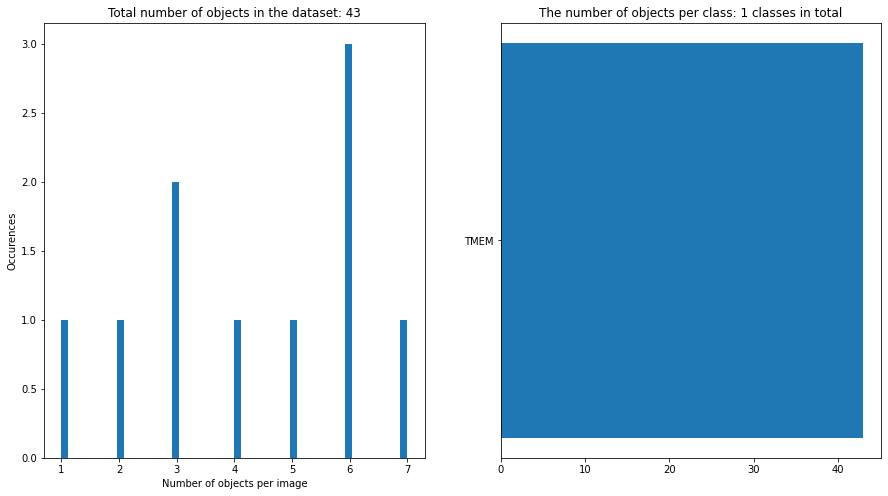

Model folder already exists and has been overwritten.
------------------------------
PDF report exported in /content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/model/TMEM_detection/


In [27]:
#@markdown ###Path to training images:

Training_Source = "/content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/Training_Images" #@param {type:"string"}

# Ground truth images
Training_Source_annotations = "/content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/Training_Annotations_old" #@param {type:"string"}

# model name and path
#@markdown ###Name of the model and path to model folder:
model_name = "TMEM_detection" #@param {type:"string"}
model_path = "/content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/model" #@param {type:"string"}

# backend
#@markdown ###Choose a backend
backend = "Full Yolo" #@param ["Select Model","Full Yolo","Inception3","SqueezeNet","MobileNet","Tiny Yolo"]

full_model_path = os.path.join(model_path,model_name)
if os.path.exists(full_model_path):
  print(bcolors.WARNING+'Model folder already exists and will be overwritten.'+bcolors.NORMAL)


# other parameters for training.
# @markdown ###Training Parameters
# @markdown Number of epochs:

number_of_epochs =  27#@param {type:"number"}

# !sed -i 's@\"nb_epochs\":.*,@\"nb_epochs\":            $number_of_epochs,@g' config.json

# #@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = False #@param {type:"boolean"}

#@markdown ###If not, please input:
train_times =  4#@param {type:"integer"}
batch_size =  16#@param {type:"number"}
learning_rate = 1e-4 #@param{type:"number"}
false_negative_penalty = 10 #@param{type:"number"}
false_positive_penalty = 1.0 #@param{type:"number"}
position_size_penalty = 1.0 #@param{type:"number"}
false_class_penalty = 1.0 #@param{type:"number"}
percentage_validation =  10#@param{type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  train_times = 4
  batch_size = 8
  learning_rate = 1e-4
  false_negative_penalty = 5.0
  false_positive_penalty = 1.0
  position_size_penalty = 1.0
  false_class_penalty = 1.0
  percentage_validation = 10

df_anno = []
dir_anno = Training_Source_annotations
for fnm in os.listdir(dir_anno):  
    if not fnm.startswith('.'): ## do not include hidden folders/files
        tree = ET.parse(os.path.join(dir_anno,fnm))
        row = extract_single_xml_file(tree)
        row["fileID"] = os.path.splitext(fnm)[0]
        df_anno.append(row)
df_anno = pd.DataFrame(df_anno)

maxNobj = np.max(df_anno["Nobj"])
totalNobj = np.sum(df_anno["Nobj"])


class_obj = []
for ibbx in range(maxNobj):
    class_obj.extend(df_anno["bbx_{}_name".format(ibbx)].values)
class_obj = np.array(class_obj)

count             = Counter(class_obj[class_obj != 'nan'])
print(count)
class_nm          = list(count.keys())
class_labels = json.dumps(class_nm)
class_count       = list(count.values())
asort_class_count = np.argsort(class_count)

class_nm          = np.array(class_nm)[asort_class_count]
class_count       = np.array(class_count)[asort_class_count]

xs = range(len(class_count))


#Show how many objects there are in the images
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.hist(df_anno["Nobj"].values,bins=50)
plt.title("Total number of objects in the dataset: {}".format(totalNobj))
plt.xlabel('Number of objects per image')
plt.ylabel('Occurences')

plt.subplot(1,2,2)
plt.barh(xs,class_count)
plt.yticks(xs,class_nm)
plt.title("The number of objects per class: {} classes in total".format(len(count)))
plt.show()

visualise_example = False
Use_pretrained_model = False
Use_Data_augmentation = False

full_model_path = os.path.join(model_path,model_name)
if os.path.exists(full_model_path):
  print(bcolors.WARNING+'Model folder already exists and has been overwritten.'+bcolors.NORMAL)
  shutil.rmtree(full_model_path)

# Create a new directory
os.mkdir(full_model_path)

pdf_export()

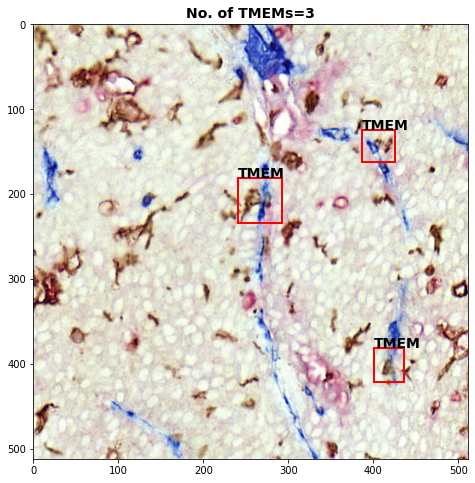

------------------------------
PDF report exported in /content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/model/TMEM_detection/


In [28]:
#@markdown ###Play this cell to visualise an example image from your dataset to make sure annotations and images are properly matched.
import imageio
visualise_example = True
size = 1 
ind_random = np.random.randint(0,df_anno.shape[0],size=size)
img_dir=Training_Source

file_suffix = os.path.splitext(os.listdir(Training_Source)[0])[1]
for irow in ind_random:
    row  = df_anno.iloc[irow,:]
    path = os.path.join(img_dir, row["fileID"] + file_suffix)
    # read in image
    img  = imageio.imread(path)

    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap='gray') # plot image
#    plt.title("No. of TMEMs={}, height={}, width={}".format(row["Nobj"],row["height"],row["width"]), fontweight='bold')
    plt.title("No. of TMEMs={}".format(row["Nobj"]), fontweight='bold', fontsize=14)
    # for each object in the image, plot the bounding box
    for iplot in range(row["Nobj"]):
        plt_rectangle(plt,
                      label = row["bbx_{}_name".format(iplot)],
                      x1=row["bbx_{}_xmin".format(iplot)],
                      y1=row["bbx_{}_ymin".format(iplot)],
                      x2=row["bbx_{}_xmax".format(iplot)],
                      y2=row["bbx_{}_ymax".format(iplot)])
#    plt.axis('off')
    plt.savefig('/content/TrainingDataExample_YOLOv2.png',bbox_inches='tight',pad_inches=0)
    plt.show() ## show the plot

pdf_export()

##**3.2. Data augmentation**
<font size = 3> Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small since, in this case, it is possible that a network could quickly learn every example in the dataset (overfitting), without augmentation. Augmentation is not necessary for training and the `Use_Data_Augmentation` box can be unticked.

<font size = 3>Here, the images and bounding boxes are augmented by flipping and rotation. When doubling the dataset the images are only flipped. With each higher factor of augmentation the images added to the dataset represent one further rotation to the right by 90 degrees. 8x augmentation will give a dataset that is fully rotated and flipped once.

Data Augmentation enabled
Augmenting 10 images
Augmenting again
And Again
And again
And again
And again


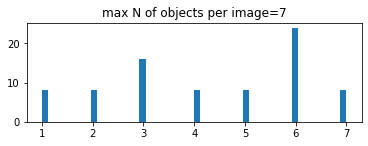

Counter({'TMEM': 344})


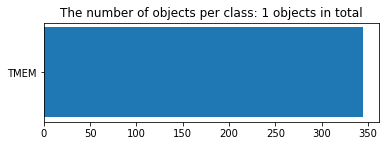

------------------------------
PDF report exported in /content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/model/TMEM_detection/


In [29]:
#@markdown ##**Augmentation Options**


Use_Data_augmentation = True #@param {type:"boolean"}

multiply_dataset_by = 8 #@param {type:"slider", min:2, max:8, step:1}

rotation_range = 90

file_suffix = os.path.splitext(os.listdir(Training_Source)[0])[1]
if (Use_Data_augmentation):
  print('Data Augmentation enabled')
  # load images as NumPy arrays and append them to images list
  if os.path.exists(Training_Source+'/.ipynb_checkpoints'):
    shutil.rmtree(Training_Source+'/.ipynb_checkpoints')
  
  images = []
  for index, file in enumerate(glob.glob(Training_Source+'/*'+file_suffix)):
      images.append(imageio.imread(file))
      
  # how many images we have
  print('Augmenting {} images'.format(len(images)))

  # apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
  labels_df = xml_to_csv(Training_Source_annotations)
  labels_df.to_csv(('/content/original_labels.csv'), index=None)
  
  # Apply flip augmentation
  aug = iaa.OneOf([    
      iaa.Fliplr(1),
      iaa.Flipud(1)
  ])
  aug_2 = iaa.Affine(rotate=rotation_range, fit_output=True)
  aug_3 = iaa.Affine(rotate=rotation_range*2, fit_output=True)
  aug_4 = iaa.Affine(rotate=rotation_range*3, fit_output=True)

  #Here we create a folder that will hold the original image dataset and the augmented image dataset
  augmented_training_source = os.path.dirname(Training_Source)+'/'+os.path.basename(Training_Source)+'_augmentation'
  if os.path.exists(augmented_training_source):
    shutil.rmtree(augmented_training_source)
  os.mkdir(augmented_training_source)

  #Here we create a folder that will hold the original image annotation dataset and the augmented image annotation dataset (the bounding boxes).
  augmented_training_source_annotation = os.path.dirname(Training_Source_annotations)+'/'+os.path.basename(Training_Source_annotations)+'_augmentation'
  if os.path.exists(augmented_training_source_annotation):
    shutil.rmtree(augmented_training_source_annotation)
  os.mkdir(augmented_training_source_annotation)

  #Create the augmentation
  augmented_images_df = image_aug(labels_df, Training_Source+'/', augmented_training_source+'/', 'flip_', aug)
  
  # Concat resized_images_df and augmented_images_df together and save in a new all_labels.csv file
  all_labels_df = pd.concat([labels_df, augmented_images_df])
  all_labels_df.to_csv('/content/combined_labels.csv', index=False)

  #Here we convert the new bounding boxes for the augmented images to PASCAL VOC .xml format
  def convert_to_xml(df,source,target_folder):
    grouped = df.groupby('filename')
    for file in os.listdir(source):
      #if file in grouped.filename:
      group_df = grouped.get_group(file)
      group_df = group_df.reset_index()
      group_df = group_df.drop(['index'], axis=1)
      #group_df = group_df.dropna(axis=0)
      writer = Writer(source+'/'+file,group_df.iloc[0]['width'],group_df.iloc[0]['height'])
      for i, row in group_df.iterrows():
        writer.addObject(row['class'],round(row['xmin']),round(row['ymin']),round(row['xmax']),round(row['ymax']))
        writer.save(target_folder+'/'+os.path.splitext(file)[0]+'.xml')
  convert_to_xml(all_labels_df,augmented_training_source,augmented_training_source_annotation)
  
  #Second round of augmentation
  if multiply_dataset_by > 2:
    aug_labels_df_2 = xml_to_csv(augmented_training_source_annotation)
    augmented_images_2_df = image_aug(aug_labels_df_2, augmented_training_source+'/', augmented_training_source+'/', 'rot1_90_', aug_2)
    all_aug_labels_df = pd.concat([augmented_images_df, augmented_images_2_df])
  #all_labels_df.to_csv('/content/all_labels_aug.csv', index=False)
  
    for file in os.listdir(augmented_training_source_annotation):
      os.remove(os.path.join(augmented_training_source_annotation,file))
    convert_to_xml(all_aug_labels_df,augmented_training_source,augmented_training_source_annotation)

  if multiply_dataset_by > 3:
    print('Augmenting again')
    aug_labels_df_3 = xml_to_csv(augmented_training_source_annotation)
    augmented_images_3_df = image_aug(aug_labels_df_3, augmented_training_source+'/', augmented_training_source+'/', 'rot2_90_', aug_2)
    all_aug_labels_df_3 = pd.concat([all_aug_labels_df, augmented_images_3_df])

    for file in os.listdir(augmented_training_source_annotation):
      os.remove(os.path.join(augmented_training_source_annotation,file))
    convert_to_xml(all_aug_labels_df_3,augmented_training_source,augmented_training_source_annotation)
  
  #This is a preliminary remover of potential duplicates in the augmentation
  #Ideally, duplicates are not even produced, but this acts as a fail safe.
    if multiply_dataset_by==4:
      for file in os.listdir(augmented_training_source):
        if file.startswith('rot2_90_flip_'):
          os.remove(os.path.join(augmented_training_source,file))
          os.remove(os.path.join(augmented_training_source_annotation, os.path.splitext(file)[0]+'.xml'))

  if multiply_dataset_by > 4:
    print('And Again')
    aug_labels_df_4 = xml_to_csv(augmented_training_source_annotation)
    augmented_images_4_df = image_aug(aug_labels_df_4, augmented_training_source+'/',augmented_training_source+'/','rot3_90_', aug_2)
    all_aug_labels_df_4 = pd.concat([all_aug_labels_df_3, augmented_images_4_df])

    for file in os.listdir(augmented_training_source_annotation):
      os.remove(os.path.join(augmented_training_source_annotation,file))
    convert_to_xml(all_aug_labels_df_4,augmented_training_source,augmented_training_source_annotation)

    for file in os.listdir(augmented_training_source):
      if file.startswith('rot3_90_rot2_90_flip_'):
        os.remove(os.path.join(augmented_training_source,file))
        os.remove(os.path.join(augmented_training_source_annotation, os.path.splitext(file)[0]+'.xml'))
      if file.startswith('rot3_90_rot1_90_flip_'):
        os.remove(os.path.join(augmented_training_source,file))
        os.remove(os.path.join(augmented_training_source_annotation, os.path.splitext(file)[0]+'.xml'))
      if file.startswith('rot3_90_flip_'):
        os.remove(os.path.join(augmented_training_source,file))
        os.remove(os.path.join(augmented_training_source_annotation, os.path.splitext(file)[0]+'.xml'))
      if file.startswith('rot2_90_flip_'):
        os.remove(os.path.join(augmented_training_source,file))
        os.remove(os.path.join(augmented_training_source_annotation, os.path.splitext(file)[0]+'.xml'))


  if multiply_dataset_by > 5:
    print('And again')
    augmented_images_5_df = image_aug(labels_df, Training_Source+'/', augmented_training_source+'/', 'rot_90_', aug_2)
    all_aug_labels_df_5 = pd.concat([all_aug_labels_df_4,augmented_images_5_df])

    for file in os.listdir(augmented_training_source_annotation):
     os.remove(os.path.join(augmented_training_source_annotation,file))
    
    convert_to_xml(all_aug_labels_df_5,augmented_training_source,augmented_training_source_annotation)

  if multiply_dataset_by > 6:
    print('And again')
    augmented_images_df_6 = image_aug(labels_df, Training_Source+'/', augmented_training_source+'/', 'rot_180_', aug_3)
    all_aug_labels_df_6 = pd.concat([all_aug_labels_df_5,augmented_images_df_6])
    
    for file in os.listdir(augmented_training_source_annotation):
      os.remove(os.path.join(augmented_training_source_annotation,file))
    convert_to_xml(all_aug_labels_df_6,augmented_training_source,augmented_training_source_annotation)

  if multiply_dataset_by > 7:
    print('And again')
    augmented_images_df_7 = image_aug(labels_df, Training_Source+'/', augmented_training_source+'/', 'rot_270_', aug_4)
    all_aug_labels_df_7 = pd.concat([all_aug_labels_df_6,augmented_images_df_7])
    
    for file in os.listdir(augmented_training_source_annotation):
      os.remove(os.path.join(augmented_training_source_annotation,file))
    convert_to_xml(all_aug_labels_df_7,augmented_training_source,augmented_training_source_annotation)

  for file in os.listdir(Training_Source):
    shutil.copyfile(Training_Source+'/'+file,augmented_training_source+'/'+file)
    shutil.copyfile(Training_Source_annotations+'/'+os.path.splitext(file)[0]+'.xml',augmented_training_source_annotation+'/'+os.path.splitext(file)[0]+'.xml')

  df_anno = []
  dir_anno = augmented_training_source_annotation
  for fnm in os.listdir(dir_anno):  
      if not fnm.startswith('.'): ## do not include hidden folders/files
          tree = ET.parse(os.path.join(dir_anno,fnm))
          row = extract_single_xml_file(tree)
          row["fileID"] = os.path.splitext(fnm)[0]
          df_anno.append(row)
  df_anno = pd.DataFrame(df_anno)

  maxNobj = np.max(df_anno["Nobj"])

  #Show how many objects there are in the images
  plt.figure()
  plt.subplot(2,1,1)
  plt.hist(df_anno["Nobj"].values,bins=50)
  plt.title("max N of objects per image={}".format(maxNobj))
  plt.show()

  #Show the classes and how many there are of each in the dataset
  class_obj = []
  for ibbx in range(maxNobj):
      class_obj.extend(df_anno["bbx_{}_name".format(ibbx)].values)
  class_obj = np.array(class_obj)

  count             = Counter(class_obj[class_obj != 'nan'])
  print(count)
  class_nm          = list(count.keys())
  class_labels = json.dumps(class_nm)
  class_count       = list(count.values())
  asort_class_count = np.argsort(class_count)

  class_nm          = np.array(class_nm)[asort_class_count]
  class_count       = np.array(class_count)[asort_class_count]

  xs = range(len(class_count))

  plt.subplot(2,1,2)
  plt.barh(xs,class_count)
  plt.yticks(xs,class_nm)
  plt.title("The number of objects per class: {} objects in total".format(len(count)))
  plt.show()

else:
  print('No augmentation will be used')

pdf_export(augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)

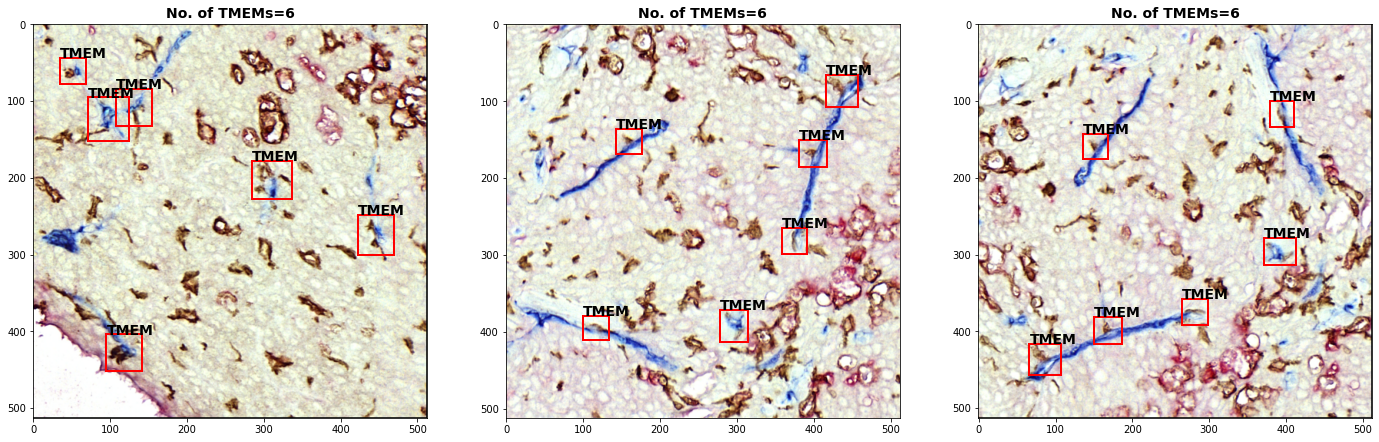

These are the augmented training images.


In [30]:
#@markdown ###Play this cell to visualise three example images from your **augmented** dataset to make sure annotations and images are properly matched.

if (Use_Data_augmentation):
  df_anno_aug = []
  dir_anno_aug = augmented_training_source_annotation
  for fnm in os.listdir(dir_anno_aug):  
      if not fnm.startswith('.'): ## do not include hidden folders/files
          tree = ET.parse(os.path.join(dir_anno_aug,fnm))
          row = extract_single_xml_file(tree)
          row["fileID"] = os.path.splitext(fnm)[0]
          df_anno_aug.append(row)
  df_anno_aug = pd.DataFrame(df_anno_aug)

  size = 3    
  ind_random = np.random.randint(0,df_anno_aug.shape[0],size=size)
  img_dir=augmented_training_source

  file_suffix = os.path.splitext(os.listdir(augmented_training_source)[0])[1]

  plt.figure(figsize=(24,24))
  for (idx, irow) in enumerate(ind_random):
      row  = df_anno_aug.iloc[irow,:]
      path = os.path.join(img_dir, row["fileID"] + file_suffix)
      # read in image
      img  = imageio.imread(path)

      plt.subplot(1,3,idx+1)
#      plt.axis('off')
      plt.imshow(img, cmap='gray') # plot image
#      plt.title("No. of TMEMs={}, height={}, width={}".format(row["Nobj"],row["height"],row["width"]), fontweight='bold')
      plt.title("No. of TMEMs={}".format(row["Nobj"]), fontweight='bold', fontsize=14)
      # for each object in the image, plot the bounding box
      for iplot in range(row["Nobj"]):
          plt_rectangle(plt,
                        label = row["bbx_{}_name".format(iplot)],
                        x1=row["bbx_{}_xmin".format(iplot)],
                        y1=row["bbx_{}_ymin".format(iplot)],
                        x2=row["bbx_{}_xmax".format(iplot)],
                        y2=row["bbx_{}_ymax".format(iplot)])
  plt.show() ## show the plot
  print('These are the augmented training images.')

else:
  print('Data augmentation disabled.')

#**4. Train the network**
---

## **4.1. Start training**
<font size = 3> **NOTE:** Google Colab has a time limit for processing. Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches.

<font size = 3>Once training is complete, the trained model is automatically saved on your Google Drive, in the **model_path** folder that was selected in Section 3. It is however wise to download the folder as all data can be erased at the next training if using the same folder.

In [31]:
#@markdown ##Start training

# ------------

os.chdir('/content/keras-yolo2')
if backend == "Full Yolo":
  if not os.path.exists('/content/keras-yolo2/full_yolo_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/full_yolo_backend.h5
elif backend == "Inception3":
  if not os.path.exists('/content/keras-yolo2/inception_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/inception_backend.h5
elif backend == "MobileNet":
  if not os.path.exists('/content/keras-yolo2/mobilenet_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/mobilenet_backend.h5
elif backend == "SqueezeNet":
  if not os.path.exists('/content/keras-yolo2/squeezenet_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/squeezenet_backend.h5
elif backend == "Tiny Yolo":
  if not os.path.exists('/content/keras-yolo2/tiny_yolo_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/tiny_yolo_backend.h5


full_model_file_path = full_model_path+'/best_weights.h5'
os.chdir('/content/keras-yolo2/')

#Change backend name
!sed -i 's@\"backend\":.*,@\"backend\":              \"$backend\",@g' config.json

#Change the name of the training folder
!sed -i 's@\"train_image_folder\":.*,@\"train_image_folder\":   \"$Training_Source/\",@g' config.json

#Change annotation folder
!sed -i 's@\"train_annot_folder\":.*,@\"train_annot_folder\":   \"$Training_Source_annotations/\",@g' config.json

#Change the name of the saved model
!sed -i 's@\"saved_weights_name\":.*,@\"saved_weights_name\":   \"$full_model_file_path\",@g' config.json

#Change warmup epochs for untrained model
!sed -i 's@\"warmup_epochs\":.*,@\"warmup_epochs\":        3,@g' config.json

#When defining a new model we should reset the pretrained model parameter
!sed -i 's@\"pretrained_weights\":.*,@\"pretrained_weights\":   \"No_pretrained_weights\",@g' config.json

!sed -i 's@\"nb_epochs\":.*,@\"nb_epochs\":            $number_of_epochs,@g' config.json

!sed -i 's@\"train_times\":.*,@\"train_times\":          $train_times,@g' config.json
!sed -i 's@\"batch_size\":.*,@\"batch_size\":           $batch_size,@g' config.json
!sed -i 's@\"learning_rate\":.*,@\"learning_rate\":        $learning_rate,@g' config.json
!sed -i 's@\"object_scale":.*,@\"object_scale\":         $false_negative_penalty,@g' config.json
!sed -i 's@\"no_object_scale":.*,@\"no_object_scale\":      $false_positive_penalty,@g' config.json
!sed -i 's@\"coord_scale\":.*,@\"coord_scale\":          $position_size_penalty,@g' config.json
!sed -i 's@\"class_scale\":.*,@\"class_scale\":          $false_class_penalty,@g' config.json

#Write the annotations to a csv file
df_anno.to_csv(full_model_path+'/annotations.csv', index=False)#header=False, sep=',')

!sed -i 's@\"labels\":.*@\"labels\":               $class_labels@g' config.json


#Generate anchors for the bounding boxes
os.chdir('/content/keras-yolo2')
output = sp.getoutput('python ./gen_anchors.py -c ./config.json')

anchors_1 = output.find("[")
anchors_2 = output.find("]")

config_anchors = output[anchors_1:anchors_2+1]
!sed -i 's@\"anchors\":.*,@\"anchors\":              $config_anchors,@g' config.json


!sed -i 's@\"pretrained_weights\":.*,@\"pretrained_weights\":   \"$h5_file_path\",@g' config.json


# !sed -i 's@\"anchors\":.*,@\"anchors\":              $config_anchors,@g' config.json


if Use_pretrained_model:
  !sed -i 's@\"warmup_epochs\":.*,@\"warmup_epochs\":        0,@g' config.json
  !sed -i 's@\"learning_rate\":.*,@\"learning_rate\":        $learning_rate,@g' config.json

if Use_Data_augmentation:
  #Change the name of the training folder
  !sed -i 's@\"train_image_folder\":.*,@\"train_image_folder\":   \"$augmented_training_source/\",@g' config.json

  #Change annotation folder
  !sed -i 's@\"train_annot_folder\":.*,@\"train_annot_folder\":   \"$augmented_training_source_annotation/\",@g' config.json


# ------------



if os.path.exists(full_model_path+"/Quality Control"):
  shutil.rmtree(full_model_path+"/Quality Control")
os.makedirs(full_model_path+"/Quality Control")


start = time.time()

os.chdir('/content/keras-yolo2')
train('config.json', full_model_path, percentage_validation)

shutil.copyfile('/content/keras-yolo2/config.json',full_model_path+'/config.json')

if os.path.exists('/content/keras-yolo2/best_map_weights.h5'):
  shutil.move('/content/keras-yolo2/best_map_weights.h5',full_model_path+'/best_map_weights.h5')

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")

#Create a pdf document with training summary

pdf_export(trained = True, augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)

Seen labels:	 {'TMEM': 344}
Given labels:	 ['TMEM']
Overlap labels:	 {'TMEM'}
(13, 13)
Epoch 1/30
 - 22s - loss: 10.1037 - val_loss: 10.1203

Epoch 00001: val_loss improved from inf to 10.12029, saving model to /content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/model/TMEM_detection/best_weights.h5


TMEM 0.0219
mAP: 0.0219
mAP improved from 0 to 0.021874166566421646, saving model to /content/keras-yolo2/best_map_weights.h5.
Epoch 2/30
 - 15s - loss: 10.0451 - val_loss: 10.0381

Epoch 00002: val_loss improved from 10.12029 to 10.03807, saving model to /content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/model/TMEM_detection/best_weights.h5


TMEM 0.0229
mAP: 0.0229
mAP improved from 0.021874166566421646 to 0.022859322110209187, saving model to /content/keras-yolo2/best_map_weights.h5.
Epoch 3/30
 - 15s - loss: 10.0197 - val_loss: 10.0156

Epoch 00003: val_loss improved from 10.03807 to 10.01564, saving model to /content/gdrive/MyDrive/Image_anal

# **5. Evaluate your model**
---

<font size = 3>This section allows the user to perform important quality checks on the validity and generalisability of the trained model. 

<font size = 3>We highly recommend to perform quality control on all newly trained models.



In [32]:
# model name and path
#@markdown ###Do you want to assess the model you just trained ?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, please provide the name of the model folder:

QC_model_folder = "" #@param {type:"string"}

if (Use_the_current_trained_model): 
  QC_model_folder = full_model_path

#print(os.path.join(model_path, model_name))

QC_model_name = os.path.basename(QC_model_folder)

if os.path.exists(QC_model_folder):
  print("The "+QC_model_name+" model will be evaluated")
else:
  W  = '\033[0m'  # white (normal)
  R  = '\033[31m' # red
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path before proceeding further.')

if Use_the_current_trained_model == False:
  if os.path.exists('/content/keras-yolo2/config.json'):
    os.remove('/content/keras-yolo2/config.json')
  shutil.copyfile(QC_model_folder+'/config.json','/content/keras-yolo2/config.json')

#@markdown ###Which backend is the model using?
backend = "Full Yolo" #@param ["Select Model","Full Yolo","Inception3","SqueezeNet","MobileNet","Tiny Yolo"]
os.chdir('/content/keras-yolo2')
if backend == "Full Yolo":
  if not os.path.exists('/content/keras-yolo2/full_yolo_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/full_yolo_backend.h5
elif backend == "Inception3":
  if not os.path.exists('/content/keras-yolo2/inception_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/inception_backend.h5
elif backend == "MobileNet":
  if not os.path.exists('/content/keras-yolo2/mobilenet_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/mobilenet_backend.h5
elif backend == "SqueezeNet":
  if not os.path.exists('/content/keras-yolo2/squeezenet_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/squeezenet_backend.h5
elif backend == "Tiny Yolo":
  if not os.path.exists('/content/keras-yolo2/tiny_yolo_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/tiny_yolo_backend.h5


The TMEM_detection model will be evaluated


## **5.1. Inspection of the loss function**
<font size = 3>Evaluate the training progress by comparing the training loss with the validation loss.

<font size = 3>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 3>**Validation loss** describes the same error value between the model's prediction on a validation image and it's target.

<font size = 3>**mean Average Precision (mAP) score:** This refers to the mean average precision of the model on the given dataset. This value gives an indication of how precise the predictions of the classes are when compared to the ground-truth. Values closer to 1 indicate a good fit.

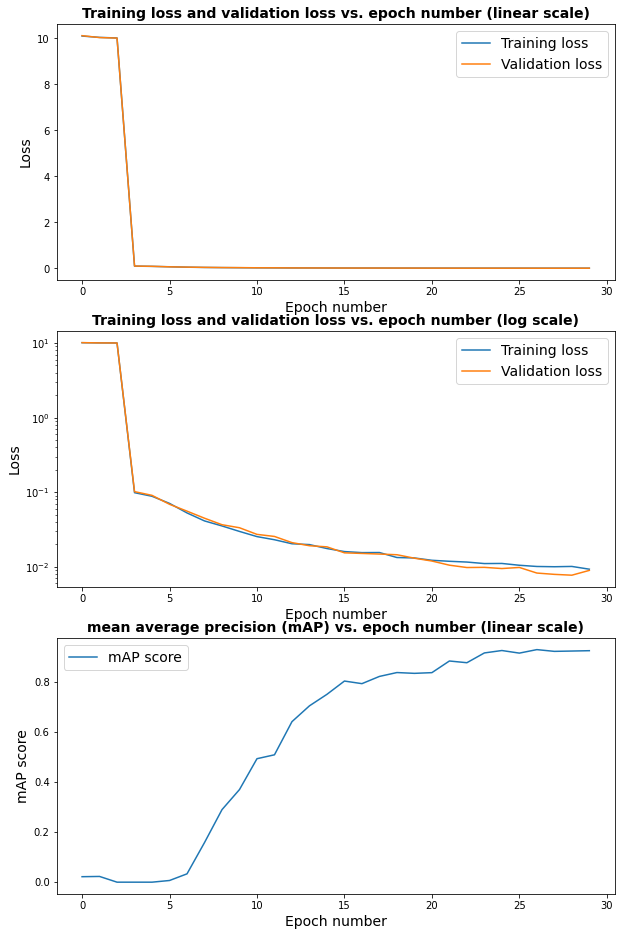

In [33]:
#@markdown ##Play the cell to show a plot of training errors vs. epoch number
import csv
from matplotlib import pyplot as plt

lossDataFromCSV = []
vallossDataFromCSV = []
mAPDataFromCSV = []
with open(QC_model_folder+'/Quality Control/training_evaluation.csv','r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    next(csvRead)
    for row in csvRead:
        lossDataFromCSV.append(float(row[0]))
        vallossDataFromCSV.append(float(row[1]))
        mAPDataFromCSV.append(float(row[2]))
epochNumber = range(len(lossDataFromCSV))
plt.figure(figsize=(10,16))

plt.subplot(3,1,1)
plt.plot(epochNumber,lossDataFromCSV, label='Training loss')
plt.plot(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)', fontweight='bold', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch number', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(3,1,2)
plt.semilogy(epochNumber,lossDataFromCSV, label='Training loss')
plt.semilogy(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)', fontweight='bold', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch number', fontsize=14)
plt.legend(fontsize=14)
#plt.savefig(os.path.dirname(QC_model_folder)+'/Quality Control/lossCurvePlots.png')
#plt.show()

plt.subplot(3,1,3)
plt.plot(epochNumber,mAPDataFromCSV, label='mAP score')
plt.title('mean average precision (mAP) vs. epoch number (linear scale)', fontweight='bold', fontsize=14)
plt.ylabel('mAP score', fontsize=14)
plt.xlabel('Epoch number', fontsize=14)
plt.legend(fontsize=14)
#plt.savefig(QC_model_folder+'/Quality Control/lossCurveAndmAPPlots.png',bbox_inches='tight', pad_inches=0)
plt.savefig(QC_model_folder+'/Quality Control/lossCurveAndmAPPlots.png')
plt.show()

# **6. TMEM predictions in unseen images**
---

## **6.1. Setting the path to the unseen dataset**
---

<font size = 3>The current trained model (from section 4.2) can now be used to process images. Predicted output images are saved in your **Result_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 3>**`Data_folder`:** This folder should contain the images that you want to use your trained network on for processing.

<font size = 3>**`Result_folder`:** This folder will contain the predicted output images.

<font size = 3>**`Prediction_model_path`:** This should be the folder that contains your model.

<font size = 3>Since the training saves three different models, for the best validation loss (`best_weights`), best average precision (`best_mAP_weights`) and the model after the last epoch (`last_weights`), you should choose which ones you want to use for prediction. We recommend using `best_map_weights` because they should yield the best performance on the dataset. However, it can be worth testing how well `best_weights` perform too.

In [34]:
Data_folder = "/content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/Test_Images" #@param {type:"string"}
Result_folder = "/content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/Test_Annotations" #@param {type:"string"}
file_suffix = os.path.splitext(os.listdir(Data_folder)[0])[1]

# model name and path
#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, provide the name of the model and path to model folder:

Prediction_model_path = "" #@param {type:"string"}

#@markdown ###Which model do you want to use?
model_choice = "best_map_weights" #@param["best_weights","last_weights","best_map_weights"]

#@markdown ###Which backend is the model using?
backend = "Full Yolo" #@param ["Select Model","Full Yolo","Inception3","SqueezeNet","MobileNet","Tiny Yolo"]


os.chdir('/content/keras-yolo2')
if backend == "Full Yolo":
  if not os.path.exists('/content/keras-yolo2/full_yolo_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/full_yolo_backend.h5
elif backend == "Inception3":
  if not os.path.exists('/content/keras-yolo2/inception_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/inception_backend.h5
elif backend == "MobileNet":
  if not os.path.exists('/content/keras-yolo2/mobilenet_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/mobilenet_backend.h5
elif backend == "SqueezeNet":
  if not os.path.exists('/content/keras-yolo2/squeezenet_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/squeezenet_backend.h5
elif backend == "Tiny Yolo":
  if not os.path.exists('/content/keras-yolo2/tiny_yolo_backend.h5'):
    !wget https://github.com/rodrigo2019/keras_yolo2/releases/download/pre-trained-weights/tiny_yolo_backend.h5
if (Use_the_current_trained_model): 
  print("Using current trained network")
  Prediction_model_path = full_model_path

if Use_the_current_trained_model == False:
  if os.path.exists('/content/keras-yolo2/config.json'):
    os.remove('/content/keras-yolo2/config.json')
  shutil.copyfile(Prediction_model_path+'/config.json','/content/keras-yolo2/config.json')

if os.path.exists(Prediction_model_path+'/'+model_choice+'.h5'):
  print("The "+os.path.basename(Prediction_model_path)+" network will be used.")
else:
  W  = '\033[0m'  # white (normal)
  R  = '\033[31m' # red
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')

# Provide the code for performing predictions and saving them
print("Images will be saved into folder:", Result_folder)


# ----- Predictions ------

start = time.time()

#Remove any files that might be from the prediction of QC examples.
if os.path.exists('/content/predicted_bounding_boxes.csv'):
  os.remove('/content/predicted_bounding_boxes.csv')
if os.path.exists('/content/predicted_bounding_boxes_new.csv'):
  os.remove('/content/predicted_bounding_boxes_new.csv')
if os.path.exists('/content/predicted_bounding_boxes_names.csv'):
  os.remove('/content/predicted_bounding_boxes_names.csv')
if os.path.exists('/content/predicted_bounding_boxes_names_new.csv'):
  os.remove('/content/predicted_bounding_boxes_names_new.csv')

os.chdir('/content/keras-yolo2')

if os.path.exists(Data_folder+'/.ipynb_checkpoints'):
  shutil.rmtree(Data_folder+'/.ipynb_checkpoints')

n_objects = []
for img in os.listdir(Data_folder):
  full_image_path = Data_folder+'/'+img
  n_obj = predict('config.json',Prediction_model_path+'/'+model_choice+'.h5',full_image_path)#,Result_folder)
  n_objects.append(n_obj)
  K.clear_session()
for img in os.listdir(Data_folder):
  if img.endswith('detected'+file_suffix):
    shutil.move(Data_folder+'/'+img,Result_folder+'/'+img)

if os.path.exists('/content/predicted_bounding_boxes.csv'):
  #shutil.move('/content/predicted_bounding_boxes.csv',Result_folder+'/predicted_bounding_boxes.csv')
  print('Bounding box labels and coordinates saved to '+ Result_folder)
else:
  print('For some reason the bounding box labels and coordinates were not saved. Check that your predictions look as expected.')

#Make a csv file to read into imagej macro, to create custom bounding boxes
header = ['filename']+['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']*max(n_objects)
with open('/content/predicted_bounding_boxes.csv', newline='') as inFile, open('/content/predicted_bounding_boxes_new.csv', 'w', newline='') as outfile:
    r = csv.reader(inFile)
    w = csv.writer(outfile)
    next(r, None)  # skip the first row from the reader, the old header
    # write new header
    w.writerow(header)
    # copy the rest
    for row in r:
        w.writerow(row)

df_bbox=pd.read_csv('/content/predicted_bounding_boxes_new.csv')
df_bbox=df_bbox.transpose()
new_header = df_bbox.iloc[0] #grab the first row for the header
df_bbox = df_bbox[1:] #take the data less the header row
df_bbox.columns = new_header #set the header row as the df header
df_bbox.sort_values(by='filename',axis=1,inplace=True)
df_bbox.to_csv(Result_folder+'/predicted_bounding_boxes_for_custom_ROI.csv')

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60) 
hour, mins = divmod(mins, 60) 
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")



Using current trained network
The TMEM_detection network will be used.
Images will be saved into folder: /content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/Test_Annotations
(13, 13)
3 boxes are found
(13, 13)
4 boxes are found
(13, 13)
4 boxes are found
(13, 13)
3 boxes are found
Bounding box labels and coordinates saved to /content/gdrive/MyDrive/Image_analysis/ZeroCostDL4Mic_YoloV2_TMEMdataset/Test_Annotations
Time elapsed: 0.0 hour(s) 0.0 min(s) 35 sec(s)


## **6.2. Visualization of the predicted TMEMs**



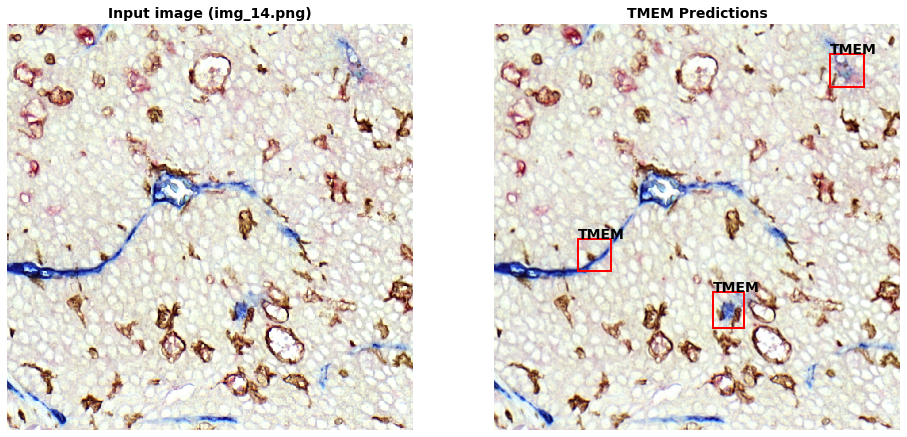

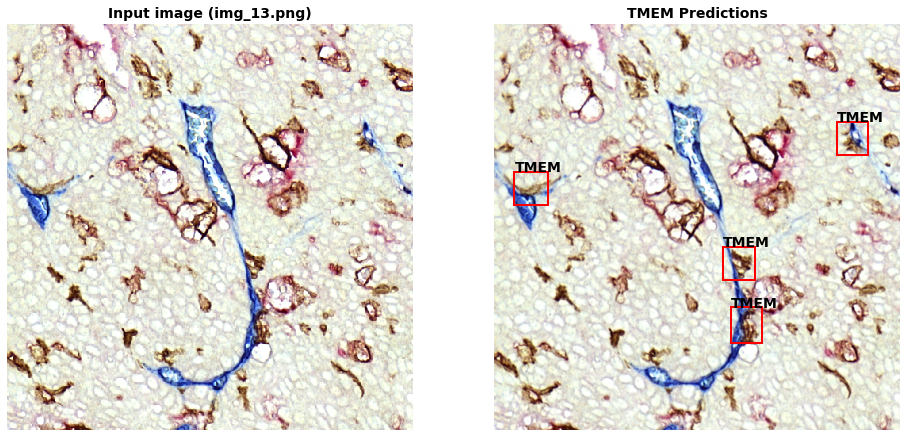

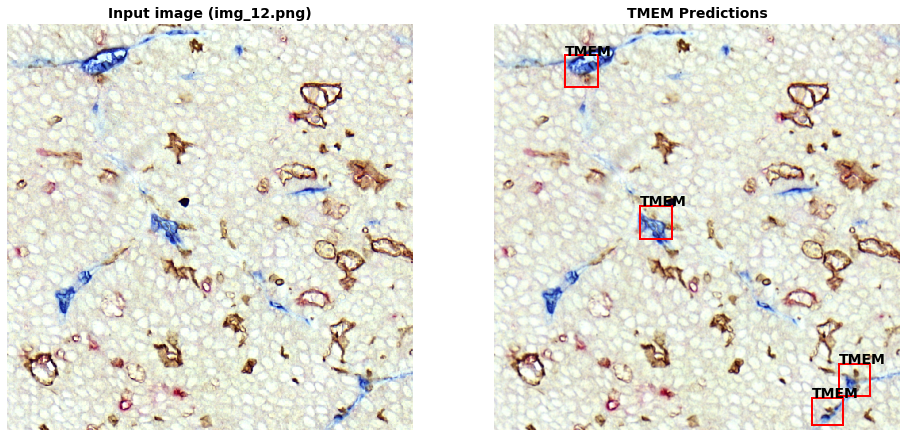

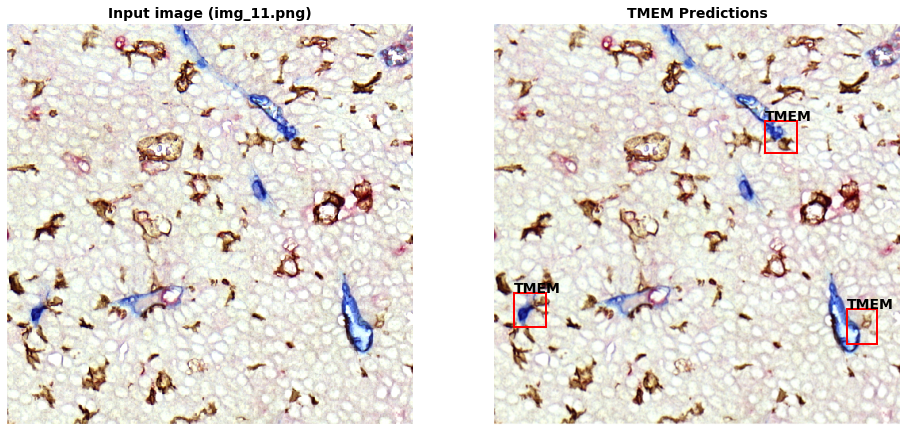

In [35]:
# @markdown ##Run this cell to display TMEM predictions on unseen images

for filename in os.listdir(Data_folder):
  x = imread(Data_folder+"/"+filename)
  os.chdir(Result_folder)
  y = imread(Result_folder+"/"+os.path.splitext(filename)[0]+'_detected'+file_suffix)

  plt.figure(figsize=(16,8))

  #plt.subplot(1,3,1)
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(x, interpolation='nearest', cmap='gray')
  plt.title('Input image ({})'.format(filename), fontweight='bold', fontsize=14)

  #plt.subplot(1,3,2)
  #plt.axis('off')
  #plt.imshow(y, interpolation='nearest')
  #plt.title('Predicted output', fontweight='bold', fontsize=14);

  add_header('/content/predicted_bounding_boxes_names.csv','/content/predicted_bounding_boxes_names_new.csv')

  #We need to edit this predicted_bounding_boxes_new.csv file slightly to display the bounding boxes
  df_bbox2 = pd.read_csv('/content/predicted_bounding_boxes_names_new.csv')
  for img in range(0,df_bbox2.shape[0]):
    df_bbox2.iloc[img]
    row = pd.DataFrame(df_bbox2.iloc[img])
    if row[img][0] == filename:
      row = row.dropna()
      image  = imageio.imread(Data_folder+'/'+row[img][0])
      #plt.figure(figsize=(12,12))
  #    plt.subplot(1,3,3)
      plt.subplot(1,2,2)
      plt.axis('off')
  #    plt.title('Alternative Display of Prediction', fontweight='bold', fontsize=14)
      plt.title('TMEM Predictions', fontweight='bold', fontsize=14)
      plt.imshow(image, cmap='gray') # plot image

      for i in range(1,int(len(row)-1),6):
        plt_rectangle(plt,
                      label = row[img][i+5],
                      x1=row[img][i],#.format(iplot)],
                      y1=row[img][i+1],
                      x2=row[img][i+2],
                      y2=row[img][i+3])#,
                      #fontsize=8)
      #plt.margins(0,0)
      #plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)
      #plt.gca().xaxis.set_major_locator(plt.NullLocator())
      #plt.gca().yaxis.set_major_locator(plt.NullLocator())
      plt.savefig('/content/detected_cells.png',bbox_inches='tight',transparent=True,pad_inches=0)
  plt.show() ## show the plot


# End of the notebook!!